## This File is for plot PT distribuition of boosted Higgs.

In [1]:
# Import useful libraries
import importlib
import numpy as np
import substructure
import matplotlib.pyplot as plt
import time
import pandas as pd
import matplotlib
matplotlib.rc('font', size=15)
import os

# Import local libraries
import csv_decoder
import save_and_load

import function as fn


In [3]:
#load Truth H->bb information
ggh_path = "/Storage/alan/FrankShower/ggh_truth_2/"
vbf_path = "/Storage/alan/FrankShower/vbf_truth_2/"
vh_path = "/Storage/alan/FrankShower/vh_truth_2/"
tth_path = "/Storage/alan/FrankShower/tth_truth_2/"
path_list = [ggh_path,vbf_path,vh_path,tth_path]
data_list = []
namelist = ["b_E","b_Px","b_Py","b_Pz","bbar_E","bbar_Px","bbar_Py","bbar_Pz","evtweight"]

for i, path in enumerate(path_list):
    data = pd.DataFrame(columns=namelist)
    num = 0
    for j, filename in enumerate(os.listdir(path)):
        if not (os.path.isfile(os.path.join(path,filename)) and (".csv" in filename)):
            continue
#         print('Currently reading: '+ str(filename))
        df = pd.read_csv(path + str(filename))
        data = pd.concat([data,df],ignore_index=True,axis=0,join='inner')
        num += 1
        
    data_list.append(data)
    
ggh, vbf, vh, tth  = data_list[0], data_list[1], data_list[2], data_list[3]
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("","ggH","VBF","VH","ttH"))
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("# of truth event",len(data_list[0]),len(data_list[1]),len(data_list[2]),len(data_list[3])))
print("number of file: {} for each process ".format(num))

                      ggH    VBF     VH    ttH  
  # of truth event   409358 683735 504036 488260
number of file: 9 for each process 


In [4]:
importlib.reload(fn)
ggh["PTH"] = fn.PT(ggh["b_Px"]+ggh["bbar_Px"],ggh["b_Py"]+ggh["bbar_Py"])
vbf["PTH"] = fn.PT(vbf["b_Px"]+vbf["bbar_Px"],vbf["b_Py"]+vbf["bbar_Py"])
vh["PTH"] = fn.PT(vh["b_Px"]+vh["bbar_Px"],vh["b_Py"]+vh["bbar_Py"])
tth["PTH"] = fn.PT(tth["b_Px"]+tth["bbar_Px"],tth["b_Py"]+tth["bbar_Py"])

ggh["M"] = fn.M(ggh["b_E"]+ggh["bbar_E"],ggh["b_Px"]+ggh["bbar_Px"],ggh["b_Py"]+ggh["bbar_Py"],ggh["b_Pz"]+ggh["bbar_Pz"])
vbf["M"] = fn.M(vbf["b_E"]+vbf["bbar_E"],vbf["b_Px"]+vbf["bbar_Px"],vbf["b_Py"]+vbf["bbar_Py"],vbf["b_Pz"]+vbf["bbar_Pz"])
vh["M"] = fn.M(vh["b_E"]+vh["bbar_E"],vh["b_Px"]+vh["bbar_Px"],vh["b_Py"]+vh["bbar_Py"],vh["b_Pz"]+vh["bbar_Pz"])
tth["M"] = fn.M(tth["b_E"]+tth["bbar_E"],tth["b_Px"]+tth["bbar_Px"],tth["b_Py"]+tth["bbar_Py"],tth["b_Pz"]+tth["bbar_Pz"])


# Reweighting

In [7]:
def for_reweight(process):
    LHCHXSWG_pt = np.linspace(400,800,int((800-400)/50+1))
    for_reweight = []
    for k in range(len(LHCHXSWG_pt)-1):
        for_reweight.append(sum(process[(process["PTH"] >= LHCHXSWG_pt[k]) & (process["PTH"] < LHCHXSWG_pt[k+1]) ]["evtweight"])/300000)
   
    return for_reweight

region1 = np.linspace(400,600,int((600-400)/10+1))
region2 = np.linspace(650,1250,int((1250-650)/50+1))
PTCUT = np.concatenate((region1,region2))
ggh_weight_origin = []
for i in range(len(PTCUT)-1):
    ggh_weight_origin.append(sum(ggh[(ggh["PTH"] >= PTCUT[i]) & (ggh["PTH"] < PTCUT[i+1]) ]["evtweight"])/300000)
ggh_weight_origin.append(sum(ggh[ggh["PTH"] >= 1250]["evtweight"])/300000)

np.save("./reweighting/ggh_bin_weight_2", np.array(ggh_weight_origin) )     
np.save("./reweighting/vbf_bin_weight_2", np.array(for_reweight(vbf)) )
np.save("./reweighting/vh_bin_weight_2", np.array(for_reweight(vh)) )
np.save("./reweighting/tth_bin_weight_2", np.array(for_reweight(tth)) )
print(sum(ggh_weight_origin))
print(sum(for_reweight(vbf)))
print(sum(for_reweight(vh)))
print(sum(for_reweight(tth)))
print(ggh_weight_origin[-2])
print(ggh_weight_origin[-1])
        

0.07282829679560114
0.01194954129913193
0.012211825545864835
0.008325984970716271
9.437803363333319e-05
0.0003398189590665224


In [12]:
def Weight(process, name, PTmin = 400 , PTmax = 2000 ):
    def reweight_bin(LHCHXSWG_process,LHCHXSWG_EW):
        LHCHXSWG_process_bin = []
        for i in range(1,len(LHCHXSWG_process)):
            LHCHXSWG_process_bin.append(LHCHXSWG_process[i-1]*(1-LHCHXSWG_EW[i]/100.)-LHCHXSWG_process[i]*(1-LHCHXSWG_EW[i]/100.))
        LHCHXSWG_process_bin = np.array(LHCHXSWG_process_bin)
        return LHCHXSWG_process_bin
    
    
    # 400,410,420,...,600,650,700,750,800,....,1250 GeV
    LHCHXSWG_ggF = np.array([33.30,29.34,25.95,22.97,20.39,18.08,16.01,14.27,12.77,11.39,
                    10.17,9.11,8.15,7.29,6.52,5.87,5.29,4.76,4.29,3.86,3.48,
                    2.13,1.32,0.84,0.54,0.36,0.24,0.16,0.11,0.0733,0.0504,0.0349,0.0243,0.0168])
    ggh_bin_weight = np.load("ggh_bin_weight.npy")
    LHCHXSWG_ggF_bin = []
    for i in range(1,len(LHCHXSWG_ggF)):
        LHCHXSWG_ggF_bin.append(LHCHXSWG_ggF[i-1]-LHCHXSWG_ggF[i])
#         LHCHXSWG_ggF_bin.append(LHCHXSWG_ggF[-1])
    LHCHXSWG_ggF_bin = np.array(LHCHXSWG_ggF_bin)
    
    
    # 400,450,500,550,600,650,700,750,800 GeV
    LHCHXSWG_VBF = np.array([14.23,8.06,4.75,2.90,1.82,1.17,0.77,0.51,0.35])
    EW_VBF = np.array([17.80,19.43,21.05,22.34,23.73,25.03,26.29,27.35,28.42])
    vbf_bin_weight = np.load("vbf_bin_weight.npy")
    
    LHCHXSWG_VH = np.array([11.16,6.87,4.39,2.87,1.91,1.30,0.90,0.62,0.44])
    EW_VH = np.array([19.05,20.83,22.50,24.07,25.56,26.98,28.30,29.60,30.83])
    vh_bin_weight = np.load("vh_bin_weight.npy")
    
    LHCHXSWG_ttH = np.array([6.89,4.24,2.66,1.76,1.11,0.72,0.47,0.32,0.22])
    EW_ttH = np.array([6.95,7.75,8.94,9.11,9.91,10.67,11.37,11.94,12.51])
    tth_bin_weight = np.load("tth_bin_weight.npy")
    
    if name == "ggF":
        LHCHXSWG_process_bin = LHCHXSWG_ggF_bin
        for_reweight = ggh_bin_weight
    elif name == "VBF":
        LHCHXSWG_process_bin = reweight_bin(LHCHXSWG_VBF,EW_VBF)
        for_reweight = vbf_bin_weight
    elif name == "VH":
        LHCHXSWG_process_bin = reweight_bin(LHCHXSWG_VH,EW_VH)
        for_reweight = vh_bin_weight
    elif name == "ttH": 
        LHCHXSWG_process_bin = reweight_bin(LHCHXSWG_ttH,EW_ttH)
        for_reweight = tth_bin_weight
        
    weight = []
    totalweight, uncertainty, uncertainty_perbin = [], [], []
    
    region1 = np.linspace(400,600,int((600-400)/10+1))
    region2 = np.linspace(650,1250,int((1250-650)/50+1))
    PTCUT_ggF = np.concatenate((region1,region2))
    LHCHXSWG_pt = np.linspace(400,800,int((800-400)/50+1))
    PTCUT = np.linspace(PTmin,PTmax,int((PTmax-PTmin)/10+1))
#     PTCUT = np.linspace(400,1250,int((1250-400)/10+1))
    
    if name == "ggF":
        k = 0

        for i in range(len(PTCUT)-1):
            if len(process[(process["PTH"] >= PTCUT[i]) & (process["PTH"] < PTCUT[i+1]) ]) == 0:
                length = i
                break
            else:
                bin_weights = process[(process["PTH"] >= PTCUT[i]) & (process["PTH"] < PTCUT[i+1]) ]["evtweight"]/300000
                reweight_factor = LHCHXSWG_process_bin[k]*0.001/for_reweight[k]

                length = i+1
            if PTCUT_ggF[k] < 1200:
                if PTCUT[i] == PTCUT_ggF[k+1]:
                    k += 1
            elif PTCUT_ggF[k] >= 1250:
                reweight_factor = 0.050843596565854896
                
            weight.append(sum(bin_weights*reweight_factor))
            uncertainty_perbin.append(np.sqrt(np.sum((bin_weights*reweight_factor)**2)))
                

#         for i in range(len(PTCUT[:length+1])):
#             totalweight.append(sum(weight[i:]))
# #             print(sum(weight[i:]))
#             uncertainty.append(np.sqrt(np.sum(np.array(uncertainty_perbin)[i:]**2)))
        for i in range(len(PTCUT[:length+1])):
            if PTCUT[i] < 1450:
                totalweight.append(sum(weight[i:np.where(PTCUT==1450)[0][0]]))
                uncertainty.append(np.sqrt(np.sum(np.array(uncertainty_perbin)[i:np.where(PTCUT==1450)[0][0]]**2)))
            elif PTCUT[i] >= 1450:
                totalweight.append(sum(weight[i:]))
                uncertainty.append(np.sqrt(np.sum(np.array(uncertainty_perbin)[i:]**2)))
    else:
        k = 0
        for i in range(len(PTCUT)-1):
            if len(process[(process["PTH"] >= PTCUT[i]) & (process["PTH"] < PTCUT[i+1]) ]) == 0:
                length = i
                break
            else:
                bin_weights = process[(process["PTH"] >= PTCUT[i]) & (process["PTH"] < PTCUT[i+1]) ]["evtweight"]/300000
                reweight_factor = LHCHXSWG_process_bin[k]*0.001/for_reweight[k]

                weight.append(sum(bin_weights*reweight_factor))
                uncertainty_perbin.append(np.sqrt(np.sum((bin_weights*reweight_factor)**2)))

                length = i+1
            if LHCHXSWG_pt[k] < 750:
                if PTCUT[i] == LHCHXSWG_pt[k+1]:
                    k += 1
            
        for i in range(len(PTCUT[:length+1])):
            totalweight.append(sum(weight[i:]))
            uncertainty.append(np.sqrt(np.sum(np.array(uncertainty_perbin)[i:]**2)))
        
            
    return PTCUT, weight, totalweight, uncertainty_perbin, uncertainty

def error_propagation(xs_1,xs_2,xs_3,xs_4,error_1,error_2,error_3,error_4):
    xs_1,xs_2,xs_3,xs_4 = np.array(xs_1),np.array(xs_2),np.array(xs_3),np.array(xs_4)
    totalerror, div_error_1, div_error_2, div_error_3, div_error_4 = [],[],[],[],[]
    totaleXS = []
    length = min(len(error_1),len(error_2),len(error_3),len(error_4))
    for i in range(length):
        totalerror.append(np.sqrt(np.array(error_1)[i]**2+np.array(error_2)[i]**2+np.array(error_3)[i]**2+np.array(error_4)[i]**2))
        totaleXS.append(xs_1[i]+xs_2[i]+xs_3[i]+xs_4[i])
    totalerror, totaleXS = np.array(totalerror), np.array(totaleXS)
    
    for i in range(length):
        div_error_1.append((xs_1[i]/totaleXS[i])*np.sqrt((error_1[i]/xs_1[i])**2+(totalerror[i]/totaleXS[i])**2))
        div_error_2.append((xs_2[i]/totaleXS[i])*np.sqrt((error_2[i]/xs_2[i])**2+(totalerror[i]/totaleXS[i])**2))
        div_error_3.append((xs_3[i]/totaleXS[i])*np.sqrt((error_3[i]/xs_3[i])**2+(totalerror[i]/totaleXS[i])**2))
        div_error_4.append((xs_4[i]/totaleXS[i])*np.sqrt((error_4[i]/xs_4[i])**2+(totalerror[i]/totaleXS[i])**2))
    
    return totalerror, div_error_1, div_error_2, div_error_3, div_error_4


def DrawCumulativeXection(ggh_weight, vbf_weight, vh_weight, tth_weight, 
                          ggh_factor=1, vbf_factor=1, vh_factor=1, tth_factor=1):
    fig, ax = plt.subplots(1,1, figsize=(9,6))

    plt.fill_between(ggh_weight[0][:len(ggh_weight[2])], np.array(ggh_weight[2])*ggh_factor
                     -np.array(ggh_weight[4])*ggh_factor, 
                     np.array(ggh_weight[2])*ggh_factor
                     +np.array(ggh_weight[4])*ggh_factor, color = 'green', alpha =0.5,linewidth=1)

    plt.fill_between(vbf_weight[0][:len(vbf_weight[2])], np.array(vbf_weight[2])*vbf_factor
                     -np.array(vbf_weight[4])*vbf_factor, 
                     np.array(vbf_weight[2])*vbf_factor
                     +np.array(vbf_weight[4])*vbf_factor, color = 'red', alpha =0.5,linewidth=1)

    plt.fill_between(vh_weight[0][:len(vh_weight[2])], np.array(vh_weight[2])*vh_factor
                     -np.array(vh_weight[4])*vh_factor, 
                     np.array(vh_weight[2])*vh_factor
                     +np.array(vh_weight[4])*vh_factor, color = 'blue', alpha =0.5,linewidth=1)

    plt.fill_between(tth_weight[0][:len(tth_weight[2])], np.array(tth_weight[2])*tth_factor
                     -np.array(tth_weight[4])*tth_factor, 
                     np.array(tth_weight[2])*tth_factor
                     +np.array(tth_weight[4])*tth_factor, color = 'magenta', alpha =0.5,linewidth=1)

    plt.plot(ggh_weight[0][:len(ggh_weight[2])],np.array(ggh_weight[2])*ggh_factor, color = "green",linewidth=3,label="ggF") #weighted
    plt.plot(vbf_weight[0][:len(vbf_weight[2])],np.array(vbf_weight[2])*vbf_factor, color = "red",linewidth=3,label="VBF") #weighted
    plt.plot(vh_weight[0][:len(vh_weight[2])],np.array(vh_weight[2])*vh_factor, color = "blue",linewidth=3,label="VH") #weighted
    plt.plot(tth_weight[0][:len(tth_weight[2])],np.array(tth_weight[2])*tth_factor, color = "magenta",linewidth=3,label="ttH") #weighted

    plt.yscale("log")
    plt.xlim((400,1250))
    plt.ylim((1E-6,1E-1))
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.set_ticks_position('both')
    plt.tick_params(axis='y', which='both', labelleft='on',labelright=0,direction="in")
    plt.tick_params(axis='x', direction="in")
    plt.grid(True)
    plt.xlabel('$P^H_{t}$ [GeV]', fontsize=25,horizontalalignment='right',x=1)
    plt.ylabel("$\sum(p^H_t)$ [pb] ",fontsize=25,horizontalalignment='right',y=1)
    plt.legend(ncol=1,fontsize=20)
    plt.tight_layout()


    # plt.savefig("./Higgs_Pt/Cumulative_Xection", transparent=True)
    plt.show()
    
    
def DrawFractional(ggh_weight, vbf_weight, vh_weight, tth_weight, 
                   ggh_factor=1, vbf_factor=1, vh_factor=1, tth_factor=1):
    
    fig, ax = plt.subplots(1,1, figsize=(9,6))

    length = min(len(ggh_weight[2]),len(vbf_weight[2]),len(vh_weight[2]),len(tth_weight[2]))-1

    error = error_propagation(np.array(ggh_weight[2][:length])*ggh_factor,
                              np.array(vbf_weight[2][:length])*vbf_factor,
                              np.array(vh_weight[2][:length])*vh_factor ,
                              np.array(tth_weight[2][:length])*tth_factor,
                              np.array(ggh_weight[4][:length])*ggh_factor,
                              np.array(vbf_weight[4][:length])*vbf_factor,
                              np.array(vh_weight[4][:length])*vh_factor ,
                              np.array(tth_weight[4][:length])*tth_factor
                             )

    total_Xection = []
    vbf_rate, vh_rate, tth_rate = [], [], []


    for i in range(length): 
        total_Xection.append(np.array(ggh_weight[2])[i]*ggh_factor +\
                    np.array(vbf_weight[2])[i]*vbf_factor + \
                    np.array(vh_weight[2])[i]*vh_factor + \
                    np.array(tth_weight[2])[i]*tth_factor)

    total_Xection = np.array(total_Xection)

    plt.fill_between(ggh_weight[0][:length], np.array(ggh_weight[2])[:length]/total_Xection*ggh_factor 
                     -np.array(error[1]), 
                     np.array(ggh_weight[2])[:length]/total_Xection*ggh_factor 
                     +np.array(error[1]), color = 'green', alpha =0.5,linewidth=1)

    plt.fill_between(vbf_weight[0][:length], np.array(vbf_weight[2])[:length]/total_Xection*vbf_factor
                     -np.array(error[2]), 
                     np.array(vbf_weight[2])[:length]/total_Xection*vbf_factor
                     +np.array(error[2]), color = 'red', alpha =0.5,linewidth=1)

    plt.fill_between(vh_weight[0][:length], np.array(vh_weight[2])[:length]/total_Xection*vh_factor
                     -np.array(error[3]), 
                     np.array(vh_weight[2])[:length]/total_Xection*vh_factor
                     +np.array(error[3]), color = 'blue', alpha =0.5,linewidth=1)

    plt.fill_between(tth_weight[0][:length], np.array(tth_weight[2])[:length]/total_Xection*tth_factor
                     -np.array(error[4]), 
                     np.array(tth_weight[2])[:length]/total_Xection*tth_factor
                     +np.array(error[4]), color = 'magenta', alpha =0.5,linewidth=1)
    
    plt.plot(ggh_weight[0][:length],np.array(ggh_weight[2])[:length]/total_Xection*ggh_factor , color = "green",linewidth=3,label="ggF") #weighted
    plt.plot(vbf_weight[0][:length],np.array(vbf_weight[2])[:length]/total_Xection*vbf_factor, color = "red",linewidth=3,label="VBF") #weighted
    plt.plot(vh_weight[0][:length],np.array(vh_weight[2])[:length]/total_Xection*vh_factor, color = "blue",linewidth=3,label="VH") #weighted
    plt.plot(tth_weight[0][:length],np.array(tth_weight[2])[:length]/total_Xection*tth_factor, color = "magenta",linewidth=3,label="ttH") #weighted

    # plt.yscale("log")
    plt.xlim((400,1250))
    plt.ylim((0,1))
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.set_ticks_position('both')
    plt.tick_params(axis='y', which='both', labelleft='on',labelright=0,direction="in")
    plt.tick_params(axis='x', direction="in")
    plt.grid(True)
    plt.xlabel('$P^H_{t}$ [GeV]', fontsize=25,horizontalalignment='right',x=1)
    plt.ylabel("Fractional Contribution",fontsize=20,horizontalalignment='right',y=1)
    plt.legend(ncol=1,fontsize=20)
    plt.tight_layout()

    # plt.savefig("./Higgs_Pt/CumulativeXection_w_BDTcut_Ratio", transparent=True)
    plt.show()

# Cumulative Cross Section w/o Decay and Preselection

In [5]:
importlib.reload(fn)
# ggh_new_weight = ReWeight(ggh, PTCUTmax = 2500)
ggh_weight = fn.Weight(ggh, "ggF", index=2)
vbf_weight = fn.Weight(vbf, "VBF", index=2)
vh_weight = fn.Weight(vh, "VH", index=2)
tth_weight = fn.Weight(tth, "ttH", index=2)

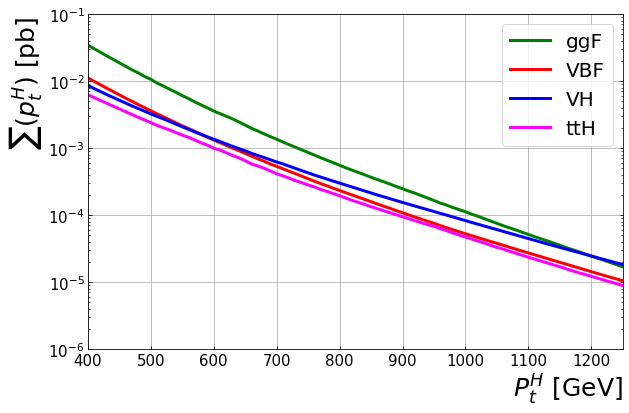

In [6]:
importlib.reload(fn)
fn.DrawCumulativeXection(ggh_weight, vbf_weight, vh_weight, tth_weight, 
                      ggh_factor=1, vbf_factor=1, vh_factor=1, tth_factor=1)

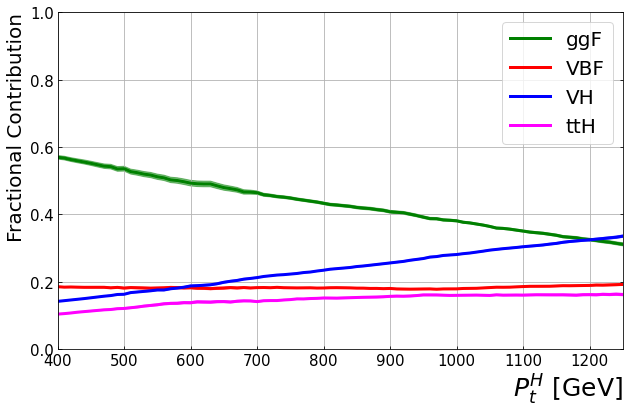

In [7]:
importlib.reload(fn)
fn.DrawFractional(ggh_weight, vbf_weight, vh_weight, tth_weight, 
               ggh_factor=1, vbf_factor=1, vh_factor=1, tth_factor=1)

In [ ]:
importlib.reload(save_and_load)
# time counter
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
############################################################################################################################################################
# save_and_load.load(folder_name, process_name)
# ggh_event_list,ggh_mass_list, ggh_higgs_list, ggh_weight_list,ggh_image_list, ggh_recluster_images = save_and_load.load_numpy("./numpy_file_3","ggH")
# vbf_event_list,vbf_mass_list, vbf_higgs_list, vbf_weight_list, vbf_image_list, vbf_recluster_images = save_and_load.load_numpy("./numpy_file_3","VBF")
# vh_event_list,vh_mass_list, vh_higgs_list, vh_weight_list, vh_image_list, vh_recluster_images = save_and_load.load_numpy("./numpy_file_3","VH")
# tth_event_list,tth_mass_list, tth_higgs_list, tth_weight_list, tth_image_list, tth_recluster_images = save_and_load.load_numpy("./numpy_file_3","ttH")

_,_, ggh_higgs_list, _,_, _ = save_and_load.load_numpy("./numpy_file_4","ggH")
_,_, vbf_higgs_list, _, _, _ = save_and_load.load_numpy("./numpy_file_4","VBF")
_,_, vh_higgs_list, _, _, _ = save_and_load.load_numpy("./numpy_file_4","VH")
_,_, tth_higgs_list, _, _, _ = save_and_load.load_numpy("./numpy_file_4","ttH")




############################################################################################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))


Mon Jun 22 06:16:06 2020


In [ ]:
print("{:^44}".format("w/ decay and preselection "))
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("","ggH","VBF","VH","ttH"))
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("# of event ",len(ggh_higgs_list),len(vbf_higgs_list),len(vh_higgs_list),len(tth_higgs_list)))


In [9]:
ggh_decay = pd.DataFrame(data = {"PTH":ggh_higgs_list[:,0],"Eta":ggh_higgs_list[:,1],
                                 "Phi":ggh_higgs_list[:,2],"M":ggh_higgs_list[:,3],
                                 "evtweight":ggh_higgs_list[:,4],"Vtype":ggh_higgs_list[:,5]})
vbf_decay = pd.DataFrame(data = {"PTH":vbf_higgs_list[:,0],"Eta":vbf_higgs_list[:,1],
                                 "Phi":vbf_higgs_list[:,2],"M":vbf_higgs_list[:,3],
                                 "evtweight":vbf_higgs_list[:,4],"Vtype":vbf_higgs_list[:,5]})
vh_decay = pd.DataFrame(data = {"PTH":vh_higgs_list[:,0],"Eta":vh_higgs_list[:,1],
                                 "Phi":vh_higgs_list[:,2],"M":vh_higgs_list[:,3],
                                 "evtweight":vh_higgs_list[:,4],"Vtype":vh_higgs_list[:,5]})
tth_decay = pd.DataFrame(data = {"PTH":tth_higgs_list[:,0],"Eta":tth_higgs_list[:,1],
                                 "Phi":tth_higgs_list[:,2],"M":tth_higgs_list[:,3],
                                 "evtweight":tth_higgs_list[:,4],"Vtype":tth_higgs_list[:,5]})

In [10]:
vh_w = vh_decay[(vh_decay["PTH"] >= 0) & ( vh_decay["Vtype"] == 24 )]
vh_z = vh_decay[(vh_decay["PTH"] >= 0) & ( vh_decay["Vtype"] == 23 )]
print(len(vh_w),len(vh_z),len(vh_w)+len(vh_z))
print(len(vh_w)/(len(vh_w)+len(vh_z)))
print(len(vh_z)/(len(vh_w)+len(vh_z)))
zh_ratio = len(vh_z)/(len(vh_w)+len(vh_z))
wh_ratio = len(vh_w)/(len(vh_w)+len(vh_z))
print(min(ggh_decay["PTH"]))
print(min(vbf_decay["PTH"]))
print(min(vh_decay["PTH"]))
print(min(tth_decay["PTH"]))

185932 95010 280942
0.661816317958867
0.338183682041133
400.004
400.005
400.002
400.002


# Cumulative Cross Section w/ Decay and Preselection

In [11]:
importlib.reload(fn)
ggh_weight_decay = fn.Weight(ggh_decay,"ggF")
vbf_weight_decay = fn.Weight(vbf_decay,"VBF")
vh_weight_decay = fn.Weight(vh_decay,"VH")
tth_weight_decay = fn.Weight(tth_decay,"ttH")

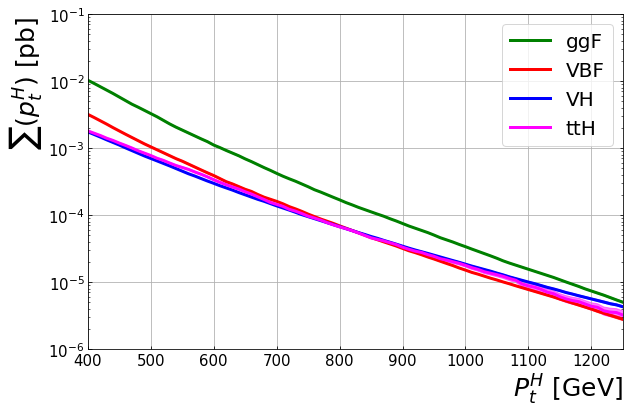

In [12]:
importlib.reload(fn)
zh_ratio, wh_ratio = 0.661816317958867, 0.338183682041133
fn.DrawCumulativeXection(ggh_weight_decay, vbf_weight_decay, vh_weight_decay, tth_weight_decay, 
                      ggh_factor=0.5824, vbf_factor=0.5824, vh_factor=0.5824*(wh_ratio*0.6741+zh_ratio*0.6991), tth_factor=0.5824,
                       note="_decay" )


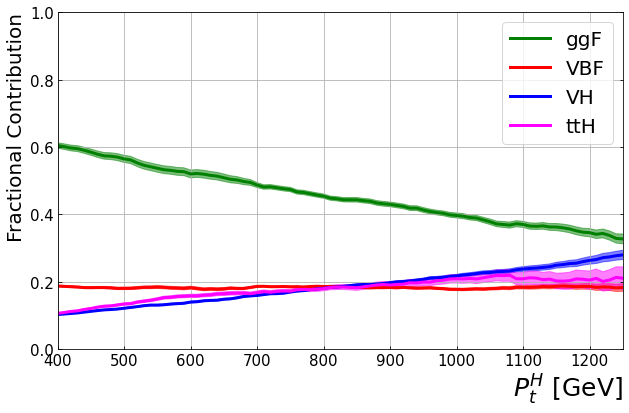

In [13]:
importlib.reload(fn)
zh_ratio, wh_ratio = 0.661816317958867, 0.338183682041133
fn.DrawFractional(ggh_weight_decay, vbf_weight_decay, vh_weight_decay, tth_weight_decay, 
                      ggh_factor=0.5824, vbf_factor=0.5824, vh_factor=0.5824*(wh_ratio*0.6741+zh_ratio*0.6991), tth_factor=0.5824,
                     note="_decay")



# Load File after adding the prediction after BDT training.

In [2]:
my_data_file_path = './BDT_Model_for_test/Data_train_w_pre.csv'
# my_data_file_path = './BDT_Model/Data_val.csv'
# my_data_file_path = './BDT_Model/Data_train.csv'
# read the data and store data in DataFrame
Data_test = pd.read_csv(my_data_file_path)

# Data_test = pd.concat([pd.read_csv('./BDT_Model/Data_test.csv'),pd.read_csv('./BDT_Model/Data_val.csv')],ignore_index=True,axis=0,join='inner')
# Data_test = pd.concat([Data_test,pd.read_csv('./BDT_Model/Data_train.csv')],ignore_index=True,axis=0,join='inner')

list = ["higgs_pt","higgs_eta","higgs_m",
           "non_higgs_leading_pt","non_higgs_leading_eta","non_higgs_leading_m",
           "non_higgs_second_pt","non_higgs_second_eta","non_higgs_second_m",
           "girth","CIJS","SIJS","DeltaEta",
            "weight","isHJ","isVBF","isVH","eventindex","prediction"]

Data_test["PTH"],Data_test["evtweight"] = Data_test["higgs_pt"],Data_test["weight"]
zh_ratio, wh_ratio = 0.661816317958867, 0.338183682041133

# ggF_Factor, VBF_Factor, VH_Factor, ttH_Factor = 228705./25000., 375024./25000., 280942./25000., 259481./25000.

ggF_Factor, VBF_Factor, VH_Factor, ttH_Factor = 229066./229000., 374654./229000., 278766./229000., 259114./229000.



In [3]:
print(len(Data_test[(Data_test["isGGH"]==1 )& (Data_test["PTH"] >= 400 )]))
print(len(Data_test[(Data_test["isVBF"]==1 )& (Data_test["PTH"] >= 400 )]))
print(len(Data_test[(Data_test["isVH"]==1 )& (Data_test["PTH"] >= 400 )]))
print(len(Data_test[(Data_test["isttH"]==1 )& (Data_test["PTH"] >= 400 )]))

228979
228991
228989
228964


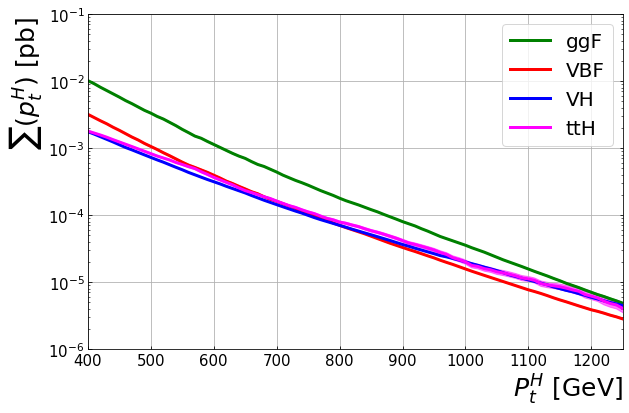

In [6]:
importlib.reload(fn)
ggF = Data_test[Data_test["isGGH"]==1]
VBF = Data_test[Data_test["isVBF"]==1]
VH = Data_test[Data_test["isVH"]==1]
ttH = Data_test[Data_test["isttH"]==1]

ggh_weight_test = fn.Weight(ggF,"ggF", index=2)
vbf_weight_test = fn.Weight(VBF,"VBF", index=2)
vh_weight_test = fn.Weight(VH,"VH", index=2)
tth_weight_test = fn.Weight(ttH,"ttH", index=2)

zh_ratio, wh_ratio = 0.661816317958867, 0.338183682041133
fn.DrawCumulativeXection(ggh_weight_test, vbf_weight_test, vh_weight_test, tth_weight_test, 
                      ggh_factor=0.5824*ggF_Factor, 
                      vbf_factor=0.5824*VBF_Factor,
                      vh_factor=0.5824*(wh_ratio*0.6741+zh_ratio*0.6991)*VH_Factor,
                      tth_factor=0.5824*ttH_Factor,
                        note = "_BDT_wo_cut")




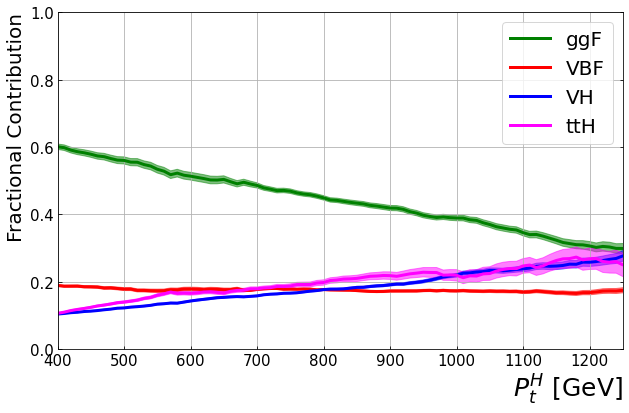

In [7]:
fn.DrawFractional(ggh_weight_test, vbf_weight_test, vh_weight_test, tth_weight_test, 
                      ggh_factor=0.5824*ggF_Factor, 
                      vbf_factor=0.5824*VBF_Factor,
                      vh_factor=0.5824*(wh_ratio*0.6741+zh_ratio*0.6991)*VH_Factor,
                      tth_factor=0.5824*ttH_Factor,
                       note = "_BDT_wo_cut")





(array([21]),)
[2213.23109971] [279.547266]
0.21000000000000005


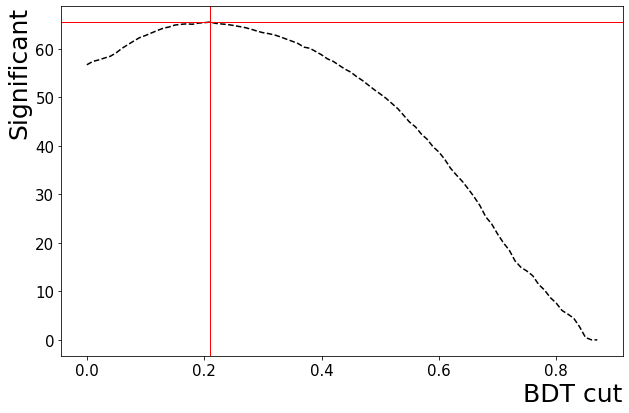

In [8]:
importlib.reload(fn)
def Z(s,b):
    z = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
#     z = s/np.sqrt(b)
    return z


Luminosity = 300 #fb-1 run3
# significance = [] 
# PTCUT = np.linspace(400,1200,81)

ptcut = 400

# for ptcut in PTCUT:
N = 100
cut = np.zeros([N+1])
NggH, NVBF, NVH, NttH, Nother = np.zeros([N+1]), np.zeros([N+1]), np.zeros([N+1]), np.zeros([N+1]), np.zeros([N+1])
cut[0] = 0
ggF = Data_test[(Data_test["isGGH"]==1) & (Data_test["prediction"] > 0) & (Data_test["PTH"] > ptcut)]    #prediction  #BDT
VBF = Data_test[(Data_test["isVBF"]==1) & (Data_test["prediction"] > 0) & (Data_test["PTH"] > ptcut)]
VH = Data_test[(Data_test["isVH"]==1) & (Data_test["prediction"] > 0) & (Data_test["PTH"] > ptcut)]
ttH = Data_test[(Data_test["isttH"]==1) & (Data_test["prediction"] > 0) & (Data_test["PTH"] > ptcut)]
Other = Data_test[(Data_test["isGGH"]!=1) & (Data_test["prediction"] > 0) & (Data_test["PTH"] > ptcut)] 

ggh_BDTcut = fn.Weight(ggF,"ggF",PTmin=ptcut, index=2)
vbf_BDTcut = fn.Weight(VBF,"VBF",PTmin=ptcut, index=2)
vh_BDTcut = fn.Weight(VH,"VH",PTmin=ptcut, index=2)
tth_BDTcut = fn.Weight(ttH,"ttH",PTmin=ptcut, index=2)


NggH[0] = (np.array(ggh_BDTcut[2])*0.5824*ggF_Factor)[0]*Luminosity*1000 
NVBF[0] = (np.array(vbf_BDTcut[2])*0.5824*VBF_Factor)[0]*Luminosity*1000 
NVH[0] =  (np.array(vh_BDTcut[2])*0.5824*(wh_ratio*0.6741+zh_ratio*0.6991)*VH_Factor)[0]*Luminosity*1000 
NttH[0] = (np.array(tth_BDTcut[2])*0.5824*ttH_Factor)[0]*Luminosity*1000 
Nother[0] = len(Other)

for i in range(N):
    cut[i+1] = cut[i] + 1./N
    ggF = Data_test[(Data_test["isGGH"]==1) & (Data_test["prediction"] > cut[i+1]) & (Data_test["PTH"] > ptcut)]
    VBF = Data_test[(Data_test["isVBF"]==1) & (Data_test["prediction"] > cut[i+1]) & (Data_test["PTH"] > ptcut)]
    VH = Data_test[(Data_test["isVH"]==1) & (Data_test["prediction"] > cut[i+1]) & (Data_test["PTH"] > ptcut)]
    ttH = Data_test[(Data_test["isttH"]==1) & (Data_test["prediction"] > cut[i+1]) & (Data_test["PTH"] > ptcut)]
    Other = Data_test[(Data_test["isGGH"]!=1) & (Data_test["prediction"] > cut[i+1]) & (Data_test["PTH"] > ptcut)]
    
    ggh_BDTcut = fn.Weight(ggF,"ggF",PTmin=ptcut, index=2)
    vbf_BDTcut = fn.Weight(VBF,"VBF",PTmin=ptcut, index=2)
    vh_BDTcut = fn.Weight(VH,"VH",PTmin=ptcut, index=2)
    tth_BDTcut = fn.Weight(ttH,"ttH",PTmin=ptcut, index=2)
    
    NggH[i+1] = (np.array(ggh_BDTcut[2])*0.5824*ggF_Factor)[0]*Luminosity*1000 
    NVBF[i+1] = (np.array(vbf_BDTcut[2])*0.5824*VBF_Factor)[0]*Luminosity*1000 
    NVH[i+1] = (np.array(vh_BDTcut[2])*0.5824*(wh_ratio*0.6741+zh_ratio*0.6991)*VH_Factor)[0]*Luminosity*1000 
    NttH[i+1] = (np.array(tth_BDTcut[2])*0.5824*ttH_Factor)[0]*Luminosity*1000 

#     if len(ggF) == 0:
#         N = i
#         break

    if NggH[i+1] <= 0:
        N = i
        break
    elif NVBF[i+1]+NVH[i+1]+NttH[i+1] ==0:
        N = i
        break

sig = np.array(Z(NggH[:N],(NVBF[:N]+NVH[:N]+NttH[:N])))
cut_opt = cut[np.where(sig == max(sig))][0]
print(np.where(sig == max(sig)))
print(NggH[np.where(sig == max(sig))],NVBF[np.where(sig == max(sig))])
print(cut_opt)

max_sig = max(sig)
# significance.append(max_sig)


fig, ax = plt.subplots(1,1, figsize=(9,6))
# plt.plot(cut[:N],Z(NggH[:N],Nother[:N]),"k--",label="Significant")
plt.plot(cut[:N],Z(NggH[:N],(NVBF[:N]+NVH[:N]+NttH[:N])),"k--",label="Significant")
ax.axvline(cut_opt , linewidth = 1, linestyle = "-", color = "red")
ax.axhline(max_sig , linewidth = 1, linestyle = "-", color = "red")

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.xlabel("BDT cut", fontsize=25,horizontalalignment='right',x=1)
plt.ylabel("Significant", fontsize=25,horizontalalignment='right',y=1)

# plt.xlim((0,1))
# plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=10)
# plt.savefig("./Higgs_Pt/sig_scan", transparent=True)
plt.tight_layout()
plt.show()


## We can easily to choose the event we want in this way.

In [10]:
BDTCUT = cut_opt
ggH_BDT_cut = Data_test[(Data_test["isGGH"]==1) & (Data_test["prediction"] >= BDTCUT) ]
VBF_BDT_cut = Data_test[(Data_test["isVBF"]==1) & (Data_test["prediction"] >= BDTCUT) ]
VH_BDT_cut = Data_test[(Data_test["isVH"]==1) & (Data_test["prediction"] >= BDTCUT) ]
ttH_BDT_cut = Data_test[(Data_test["isttH"]==1) & (Data_test["prediction"] >= BDTCUT) ]
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("","ggH","VBF","VH","ttH"))
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("# of event w/ BDT Cut ",len(ggH_BDT_cut),len(VBF_BDT_cut),len(VH_BDT_cut),len(ttH_BDT_cut)))
print(Z(len(ggH_BDT_cut),len(VBF_BDT_cut)+len(VH_BDT_cut)+len(ttH_BDT_cut)))

ggH_weight_BDT = fn.Weight(ggH_BDT_cut,"ggF", index=2)
VBF_weight_BDT = fn.Weight(VBF_BDT_cut,"VBF", index=2)
VH_weight_BDT = fn.Weight(VH_BDT_cut,"VH", index=2)
ttH_weight_BDT = fn.Weight(ttH_BDT_cut,"ttH", index=2)


                      ggH    VBF     VH    ttH  
# of event w/ BDT Cut  179599 78246  75459  83808 
332.5365743936673


# Cumulative Xection

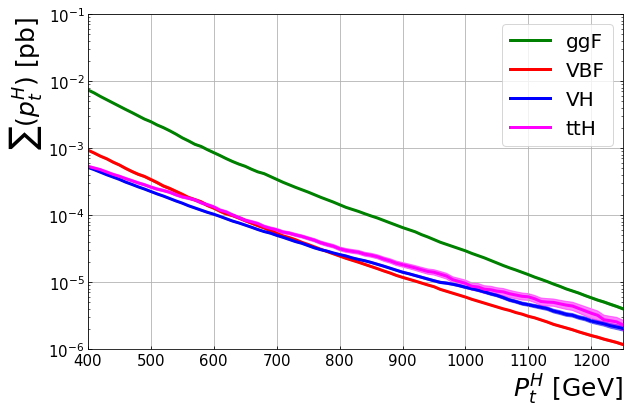

In [12]:
importlib.reload(fn)
fn.DrawCumulativeXection(ggH_weight_BDT, VBF_weight_BDT, VH_weight_BDT, ttH_weight_BDT, 
                      ggh_factor=0.5824*ggF_Factor, 
                      vbf_factor=0.5824*VBF_Factor,
                      vh_factor=0.5824*(wh_ratio*0.6741+zh_ratio*0.6991)*VH_Factor,
                      tth_factor=0.5824*ttH_Factor,
                        note="_BDT_w_cut")

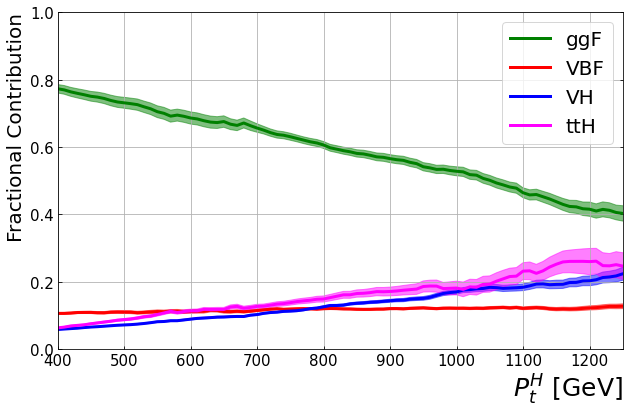

In [35]:
importlib.reload(fn)
fn.DrawFractional(ggH_weight_BDT, VBF_weight_BDT, VH_weight_BDT, ttH_weight_BDT, 
                      ggh_factor=0.5824*ggF_Factor, 
                      vbf_factor=0.5824*VBF_Factor,
                      vh_factor=0.5824*(wh_ratio*0.6741+zh_ratio*0.6991)*VH_Factor,
                      tth_factor=0.5824*ttH_Factor,
                         note="_BDT_w_cut")


# Load File after adding the prediction after 2CNN training.

In [46]:
# my_data_file_path = './BDT_Model/Data_test.csv'
my_data_file_path = './2CNN_Model_0/Data_test.csv'
# read the data and store data in DataFrame
Data_test = pd.read_csv(my_data_file_path)

list = ["higgs_pt","higgs_eta","higgs_m",
           "non_higgs_leading_pt","non_higgs_leading_eta","non_higgs_leading_m",
           "non_higgs_second_pt","non_higgs_second_eta","non_higgs_second_m",
           "girth","CIJS","SIJS","DeltaEta",
            "weight","isHJ","isVBF","isVH","eventindex","2CNN_Prediction"]

Data_test["PTH"],Data_test["evtweight"] = Data_test["higgs_pt"],Data_test["weight"]

(array([69]),)
[711.3827506] [14.90759046]
0.6900000000000004


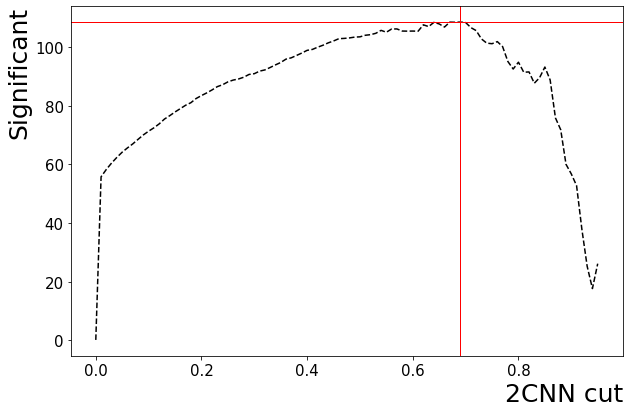

In [52]:
importlib.reload(fn)
def Z(s,b):
#     z = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
    z = s/np.sqrt(b)
    return z


Luminosity = 300 #fb-1 run3

N = 100
cut = np.zeros([N+1])
NggH, NVBF, NVH, NttH, Nother = np.zeros([N+1]), np.zeros([N+1]), np.zeros([N+1]), np.zeros([N+1]), np.zeros([N+1])
cut[0] = 0
ggH = Data_test[(Data_test["isGGH"]==1) & (Data_test["2CNN_Prediction"] > 0) & (Data_test["PTH"] > 400)]    #prediction  #BDT
VBF = Data_test[(Data_test["isVBF"]==1) & (Data_test["2CNN_Prediction"] > 0) & (Data_test["PTH"] > 400)]
VH = Data_test[(Data_test["isVH"]==1) & (Data_test["2CNN_Prediction"] > 0) & (Data_test["PTH"] > 400)]
ttH = Data_test[(Data_test["isttH"]==1) & (Data_test["2CNN_Prediction"] > 0) & (Data_test["PTH"] > 400)]
Other = Data_test[(Data_test["isGGH"]!=1) & (Data_test["2CNN_Prediction"] > 0) & (Data_test["PTH"] > 400)] 

NggH[0] = ReWeight(ggH)[2][0]*152995./25000.*0.5824
NVBF[0] = sum(VBF["weight"])/1000000.*216006./25000.*0.5824
NVH[0] =  sum(VH["weight"])/1000000.*173742./25000.*0.5824*((0.64)*0.6741 + (0.35)*0.6991)
NttH[0] = sum(ttH["weight"])/1000000.*163678./25000.*0.5824
Nother[0] = len(Other)

for i in range(N):
    cut[i+1] = cut[i] + 1./N
    ggH = Data_test[(Data_test["isGGH"]==1) & (Data_test["2CNN_Prediction"] > cut[i+1]) & (Data_test["PTH"] > 400)]
    VBF = Data_test[(Data_test["isVBF"]==1) & (Data_test["2CNN_Prediction"] > cut[i+1]) & (Data_test["PTH"] > 400)]
    VH = Data_test[(Data_test["isVH"]==1) & (Data_test["2CNN_Prediction"] > cut[i+1]) & (Data_test["PTH"] > 400)]
    ttH = Data_test[(Data_test["isttH"]==1) & (Data_test["2CNN_Prediction"] > cut[i+1]) & (Data_test["PTH"] > 400)]
    Other = Data_test[(Data_test["isGGH"]!=1) & (Data_test["2CNN_Prediction"] > cut[i+1]) & (Data_test["PTH"] > 400)]

    NggH[i+1] = ReWeight(ggH)[2][0]*152995./25000.*0.5824*Luminosity*1000 #
    NVBF[i+1] = sum(VBF["weight"])/1000000.*216006./25000.*0.5824*Luminosity*1000 
    NVH[i+1] = sum(VH["weight"])/1000000.*173742./25000.*0.5824*((0.64)*0.6741 + (0.35)*0.6991)*Luminosity*1000 
    NttH[i+1] = sum(ttH["weight"])/1000000.*163678./25000.*0.5824*Luminosity*1000 

    if len(Other) == 0:
        N = i
        break

sig = np.array(Z(NggH[:N],(NVBF[:N]+NVH[:N]+NttH[:N])))
cut_opt = cut[np.where(sig == max(sig))][0]
print(np.where(sig == max(sig)))
print(NggH[np.where(sig == max(sig))],NVBF[np.where(sig == max(sig))])
print(cut_opt)

max_sig = max(sig)


fig, ax = plt.subplots(1,1, figsize=(9,6))
# plt.plot(cut[:N],Z(NggH[:N],Nother[:N]),"k--",label="Significant")
plt.plot(cut[:N],Z(NggH[:N],(NVBF[:N]+NVH[:N]+NttH[:N])),"k--",label="Significant")
ax.axvline(cut_opt , linewidth = 1, linestyle = "-", color = "red")
ax.axhline(max_sig , linewidth = 1, linestyle = "-", color = "red")

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.xlabel("2CNN cut", fontsize=25,horizontalalignment='right',x=1)
plt.ylabel("Significant", fontsize=25,horizontalalignment='right',y=1)

# plt.xlim((0,1))
# plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=10)
# plt.savefig("./Higgs_Pt/sig_scan", transparent=True)
plt.tight_layout()
plt.show()

In [53]:
CNNCUT = cut_opt
ggH_2CNN_cut = Data_test[(Data_test["isGGH"]==1) & (Data_test["2CNN_Prediction"] >= CNNCUT) ]
VBF_2CNN_cut = Data_test[(Data_test["isVBF"]==1) & (Data_test["2CNN_Prediction"] >= CNNCUT) ]
VH_2CNN_cut = Data_test[(Data_test["isVH"]==1) & (Data_test["2CNN_Prediction"] >= CNNCUT) ]
ttH_2CNN_cut = Data_test[(Data_test["isttH"]==1) & (Data_test["2CNN_Prediction"] >= CNNCUT) ]
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("","ggH","VBF","VH","ttH"))
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("# of event w/ BDT Cut ",len(ggH_2CNN_cut),len(VBF_2CNN_cut),len(VH_2CNN_cut),len(ttH_2CNN_cut)))
print(Z(len(ggH_2CNN_cut),len(VBF_2CNN_cut)+len(VH_2CNN_cut)+len(ttH_2CNN_cut)))

print(ggH_2CNN_cut["eventindex"])
# print(ggh_weight_list[ggH_BDT_cut["eventindex"]])
# print(ggh_weight_list[142503])
print("2CNNCUT: ", cut_opt)

                      ggH    VBF     VH    ttH  
# of event w/ BDT Cut   6555   443    464    374  
183.14629235343614
1         78132
2        103078
5         33249
8        141717
17       110178
          ...  
24974    151376
24977     24923
24979    106471
24991     18449
24997     83386
Name: eventindex, Length: 6555, dtype: int64
2CNNCUT:  0.6900000000000004


# Cumulative Xection

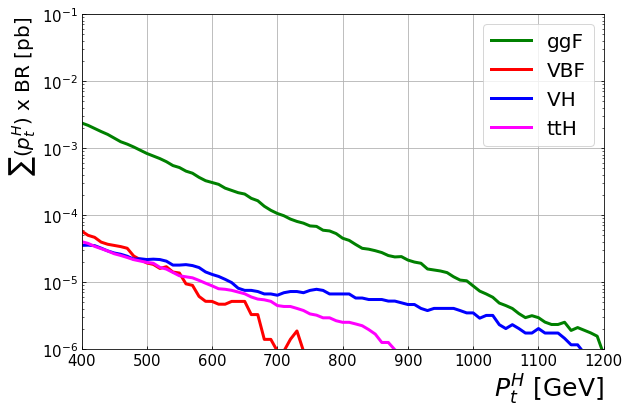

In [55]:
importlib.reload(fn)
ggH_2CNN_cut = fn.Weight(ggH_2CNN_cut,"ggF")
VBF_2CNN_cut = fn.Weight(VBF_2CNN_cut,"VBF")
VH_2CNN_cut = fn.Weight(VH_2CNN_cut,"VH")
ttH_2CNN_cut = fn.Weight(ttH_2CNN_cut,"ttH")


ggF_Factor, VBF_Factor, VH_Factor, ttH_Factor = 228705./25000., 375024./25000., 280942./25000., 259481./25000.
# ggF_Factor, VBF_Factor, VH_Factor, ttH_Factor = 228705./170000., 375024./170000., 280942./170000., 259481./170000.
zh_ratio, wh_ratio = 0.661816317958867, 0.338183682041133

fn.DrawCumulativeXection(ggH_2CNN_cut, VBF_2CNN_cut, VH_2CNN_cut, ttH_2CNN_cut, 
                      ggh_factor=0.5824*ggF_Factor, 
                      vbf_factor=0.5824*VBF_Factor,
                      vh_factor=0.5824*(wh_ratio*0.6741+zh_ratio*0.6991)*VH_Factor,
                      tth_factor=0.5824*ttH_Factor)

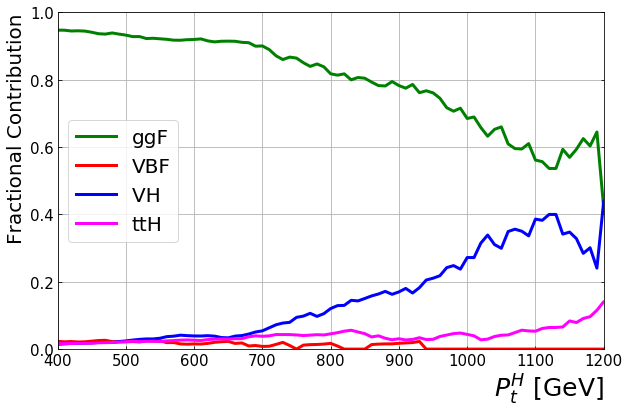

In [56]:
importlib.reload(fn)
fn.DrawFractional(ggH_2CNN_cut, VBF_2CNN_cut, VH_2CNN_cut, ttH_2CNN_cut, 
                      ggh_factor=0.5824*ggF_Factor, 
                      vbf_factor=0.5824*VBF_Factor,
                      vh_factor=0.5824*(wh_ratio*0.6741+zh_ratio*0.6991)*VH_Factor,
                      tth_factor=0.5824*ttH_Factor)

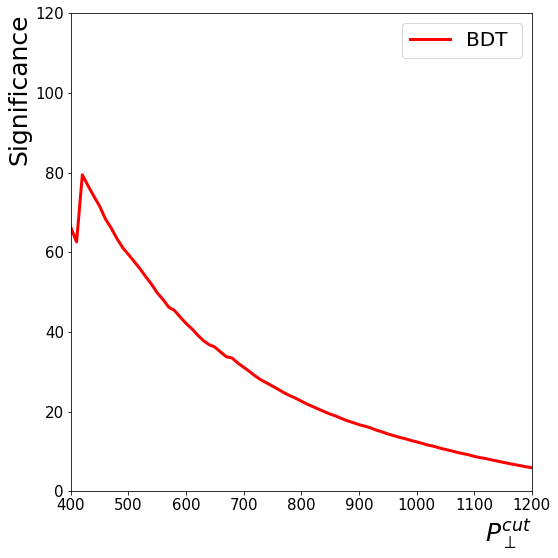

In [3]:

significance_BDT = np.load("./BDT_Model_for_test/significancescan.npy")
length = len(significance_BDT)-1
PTCUT = np.linspace(400,int(length*10+400),int(length+1))
# significance_2CNN = np.load("./2CNN_Model_0/significancescan.npy")

# fig, ax = plt.subplots(1,1, figsize=(9,6))
fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(PTCUT,significance_BDT,"r-",linewidth = 3,label="BDT ")
# plt.plot(PTCUT,significance_2CNN,"b-",linewidth = 3,label="2CNN")
# ax.axvline(cut_opt , linewidth = 1, linestyle = "-", color = "red")
# ax.axhline(max_sig , linewidth = 1, linestyle = "-", color = "red")

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.xlabel("$P^{cut}_{\perp}$", fontsize=25,horizontalalignment='right',x=1)
plt.ylabel("Significance", fontsize=25,horizontalalignment='right',y=1)

plt.xlim((400,1200))
plt.ylim((0,120))
plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=20)
# plt.savefig("./Higgs_Pt/sig_scan", transparent=True)
plt.tight_layout()
plt.show()

In [41]:
print(len(tth_higgs_list))
tth_decay = pd.DataFrame(data = {"PTH":tth_higgs_list[:,0],"Eta":tth_higgs_list[:,1],
                                 "Phi":tth_higgs_list[:,2],"M":tth_higgs_list[:,3],
                                 "evtweight":tth_higgs_list[:,4],"Vtype":tth_higgs_list[:,5]})

259481


In [210]:
def reweight_bin(LHCHXSWG_process,LHCHXSWG_EW):
    LHCHXSWG_process_bin = []
    LHCHXSWG_process_total = []
#     print(len(LHCHXSWG_process))
    for i in range(1,len(LHCHXSWG_process)):
        LHCHXSWG_process_bin.append(LHCHXSWG_process[i-1]*(1-LHCHXSWG_EW[i]/100.)-LHCHXSWG_process[i]*(1-LHCHXSWG_EW[i]/100.))
    LHCHXSWG_process_bin = np.array(LHCHXSWG_process_bin)
    for i in range(len(LHCHXSWG_process)):
        LHCHXSWG_process_total.append(LHCHXSWG_process[i]*(1-LHCHXSWG_EW[i]/100.))
    LHCHXSWG_process_total = np.array(LHCHXSWG_process_total)
    return LHCHXSWG_process_bin, LHCHXSWG_process_total


LHCHXSWG_ttH = np.array([6.89,4.24,2.66,1.76,1.11,0.72,0.47,0.32,0.22])
EW_ttH = np.array([6.95,7.75,8.94,9.11,9.91,10.67,11.37,11.94,12.51])
tth_bin_weight = np.load("tth_bin_weight.npy")

LHCHXSWG = reweight_bin(LHCHXSWG_ttH,EW_ttH)
for_reweight = tth_bin_weight

tth_decay_weight = Weight(tth_decay[tth_decay["PTH"] > 400],"ttH",PTmin=400)
tth_weight =  Weight(tth[tth["PTH"] > 400],"ttH",PTmin=400)

ttH_test = Data_test[Data_test["isttH"]==1]
ttH_Data_test = Weight(ttH_test[(ttH_test["PTH"] > 400) & (Data_test["prediction"] >= 0)],"ttH",PTmin=400)
ttH_Factor = 259481./25000.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [110]:
print(sum(tth_weight[1]))
print(sum(LHCHXSWG[0]/1000))

0.006282770457465727
0.006076509999999999


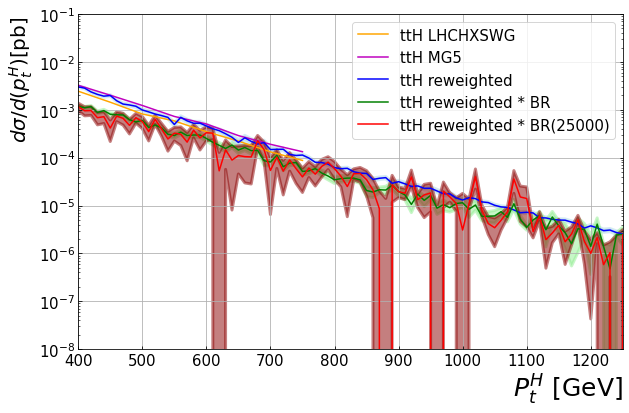

In [211]:
length = len(np.linspace(400,800,int((800-400)/50+1))[:-1])
PTCUT = np.linspace(400,2000,int((2000-400)/10+1))

fig, ax = plt.subplots(1,1, figsize=(9,6))



plt.fill_between(tth_weight[0][:-1], np.array(tth_weight[1])*5
                 -np.array(tth_weight[3])*5, 
                 np.array(tth_weight[1])*5
                 +np.array(tth_weight[3])*5, color = 'lightblue', alpha =0.5,linewidth=3)


plt.fill_between(tth_decay_weight[0][:-1], np.array(tth_decay_weight[1])*5
                 -np.array(tth_decay_weight[3])*5, 
                 np.array(tth_decay_weight[1])*5
                 +np.array(tth_decay_weight[3])*5, color = 'lightgreen', alpha =0.5,linewidth=3)

plt.fill_between(ttH_Data_test[0][:len(ttH_Data_test[1])], np.array(ttH_Data_test[1])*5*ttH_Factor
                 -np.array(ttH_Data_test[3])*5*ttH_Factor, 
                 np.array(ttH_Data_test[1])*5*ttH_Factor
                 +np.array(ttH_Data_test[3])*5*ttH_Factor, color = 'darkred', alpha =0.5,linewidth=3)

plt.plot(np.linspace(400,800,int((800-400)/50+1))[:-1],LHCHXSWG[0]/1000,c="orange",label="ttH LHCHXSWG")
plt.plot(np.linspace(400,800,int((800-400)/50+1))[:-1],for_reweight,c="m",label="ttH MG5")
plt.plot(PTCUT[:-1],np.array(tth_weight[1])*5,c="blue",label="ttH reweighted")
plt.plot(PTCUT[:-1],np.array(tth_decay_weight[1])*5,c="green",label="ttH reweighted * BR")
plt.plot(PTCUT[:len(ttH_Data_test[1])],np.array(ttH_Data_test[1])*5*ttH_Factor,c="red",label="ttH reweighted * BR(25000)")

plt.yscale("log")
plt.xlim((400,1250))
plt.ylim((1E-8,1E-1))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.yaxis.set_ticks_position('both')
plt.tick_params(axis='y', which='both', labelleft='on',labelright=0,direction="in")
plt.tick_params(axis='x', direction="in")
plt.grid(True)
plt.xlabel('$P^H_{t}$ [GeV]', fontsize=25,horizontalalignment='right',x=1)
plt.ylabel("$d\sigma/d(p^H_{t})$[pb] ",fontsize=20,horizontalalignment='right',y=1)
plt.legend(ncol=1,fontsize=15)
plt.tight_layout()
plt.show()

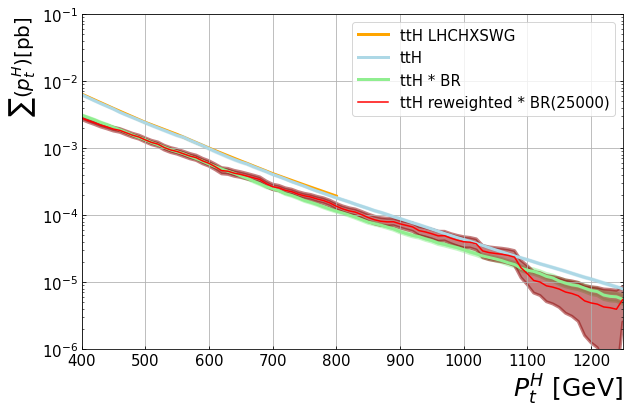

In [212]:
length = len(np.linspace(400,800,int((800-400)/50+1))[:-1])
PTCUT = np.linspace(400,2000,int((2000-400)/10+1))

fig, ax = plt.subplots(1,1, figsize=(9,6))
plt.plot(np.linspace(400,800,int((800-400)/50+1))[:],LHCHXSWG[1]/1000,c="orange",linewidth=3,label="ttH LHCHXSWG")
# plt.plot(np.linspace(400,800,int((800-400)/50+1))[:-1],for_reweight,c="m")
# plt.plot(PTCUT[:length],tth_weight[1][:length],c="b")
# plt.plot(PTCUT[:length],tth_decay_weight[1][:length],c="green")

plt.fill_between(tth_weight[0], np.array(tth_weight[2])
                 -np.array(tth_weight[4]), 
                 np.array(tth_weight[2])
                 +np.array(tth_weight[4]), color = 'lightblue', alpha =0.5,linewidth=3)


plt.fill_between(tth_decay_weight[0], np.array(tth_decay_weight[2])
                 -np.array(tth_decay_weight[4]), 
                 np.array(tth_decay_weight[2])
                 +np.array(tth_decay_weight[4]), color = 'lightgreen', alpha =0.5,linewidth=3)

plt.fill_between(ttH_Data_test[0][:len(ttH_Data_test[2])], np.array(ttH_Data_test[2])*ttH_Factor
                 -np.array(ttH_Data_test[4])*ttH_Factor, 
                 np.array(ttH_Data_test[2])*ttH_Factor
                 +np.array(ttH_Data_test[4])*ttH_Factor, color = 'darkred', alpha =0.5,linewidth=3)


plt.plot(PTCUT[:],tth_weight[2],c="lightblue",linewidth=3,label="ttH")
plt.plot(PTCUT[:],tth_decay_weight[2],c="lightgreen",linewidth=3,label="ttH * BR")
plt.plot(PTCUT[:len(ttH_Data_test[2])],np.array(ttH_Data_test[2])*ttH_Factor,c="red",label="ttH reweighted * BR(25000)")



plt.yscale("log")
plt.xlim((400,1250))
plt.ylim((1E-6,1E-1))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.yaxis.set_ticks_position('both')
plt.tick_params(axis='y', which='both', labelleft='on',labelright=0,direction="in")
plt.tick_params(axis='x', direction="in")
plt.grid(True)
plt.xlabel('$P^H_{t}$ [GeV]', fontsize=25,horizontalalignment='right',x=1)
plt.ylabel("$\sum(p^H_{t})$[pb] ",fontsize=20,horizontalalignment='right',y=1)
plt.legend(ncol=1,fontsize=15)
plt.tight_layout()
plt.show()